# Dominant Color Detection from Images

#### Date - 8th April, 2021
<hr size=5>

### Importing Necessary Libraries

In [1]:
# For Image Processing
import cv2
import imutils
from PIL import Image, ImageDraw

# For Clustering
from sklearn.cluster import KMeans

# For Formatting Data
import pandas as pd
import numpy as np
from collections import Counter
import webcolors

# For Profiling
import time
import os
import sys

# For Visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Approaches
<hr>

## 1. KMeans Clustering to find the cluster of colors present in image

#### <li>Cluster centers represents the rgb values of dominant colors

### Pros of using Kmeans Approach:
<li> Accurately finds the most dominant colors as cluster
<li> Also gets the proportion of each and every color
<li> No. of Clusters depicts no. of colors  

### Cons of using Kmeans Approach
<li> Takes a lot lof time to predict the colors for an image having a high resolution
<li> As the number of clusters increases time to prediction also increases
<br><hr>

#### Function for Kmeans to get dominant colors

In [2]:
def get_colors_using_KMeans(img):
    
    '''
    Function uses Kmeans to get the dominant colors from an Image
    Input: Image
    Output: Display Image Information and Color Deck
    '''
    
    t = time.time()
    
    # Preprocessing Image
    resized_img = cv2.resize(img, (0,0), fx=0.7, fy=0.7)
    fix_img = cv2.cvtColor(resized_img, cv2.COLOR_BGR2RGB)
    
    # Finding Clusters using Kmeans
    cluster = KMeans(n_clusters=5)
    cluster.fit(fix_img.reshape(-1,3))
    
    count = Counter(cluster.labels_)
    arr = cluster.cluster_centers_
    
    # Getting the color names list from rgb ang hex values
    final_color_list = []
    hex_list = []
    for lst in arr:
        round_value = []
        for value in lst:
            round_value.append(round(value))
        final_color_list.append(get_colour_name(round_value))
        hex_list.append(rgb_to_hex(tuple(round_value)))
    
    # Display Information
    print("Color Names: ", final_color_list)
    print("Hexadecimal Values: ", hex_list)
    print("Resolution of Image: ", str(fix_img.shape[1])+" X "+str(fix_img.shape[0]))
    print("Time for Prediction : {:.3f}".format(time.time() - t))
    
    # Display Image and color decks
    len_of_pixels = len(cluster.labels_)
    f = plt.figure(figsize=(10,7))
    f.add_subplot(1,2, 1)
    plt.imshow(fix_img)
    f.add_subplot(1,2, 2)
    plt.imshow(show_dominant_colors_frequency(arr, len(cluster.labels_), count))
    plt.show(block=True)
    
    print('\n=======================================================================\n')

### Function for KMeans to display proportions of colors present in the image

In [3]:
def show_dominant_colors_frequency(arr, len_of_pixels, count):
    
    '''
    Displays the color deck with proportions of color
    Input: Rgb values, Len of cluster Labels, count
    Ouptut: returns the color deck image
    '''
    
    # Creating color deck
    color_deck = np.zeros((50, 300, 3), dtype= np.uint8)
    no_of_pixels = len_of_pixels
    percentage = {}
    
    # Getting proportions of colors
    for i in count:
        percentage[i] = np.round((count[i] / no_of_pixels), 2)
    
    percentage = dict(sorted(percentage.items()))
    # print(percentage)
    
    # Creating the color deck with appropriate proportions
    steps = 0
    for idx, ele in enumerate(arr):
        color_deck[:, steps:int(steps+ percentage[idx]*300+1), :] = ele
        steps += int(percentage[idx]*300+1)
    
    return color_deck

## 2. Using Color Pillow Library's color palette function

#### <li>Uses getColors() function from the color palette to get the colors

### Pros of using Palette Approach:
<li> Detect colors at faster rate compared to clustering method
<li> Handles high resolution images without affecting the time complexity  
<li> Increasing the output colors by the factor of 5-6 will increase the time complexity only by 0.01-0.02 sec  

### Cons of using Palette Approach
<li> Sometimes fails to detect some colors from image   
<br><hr>

#### Function for Palette to get dominant colors

In [4]:
def get_colors_using_palette(image_file, numcolors=6, resize=150):
    
    '''
    Function uses Pillow's palette function to get the dominant colors from an Image
    Input: Image, Number of colors to find, resizing factor
    Output: Returns Rgb and Hex values
    '''
    
    # Resize image to speed up processing
    img = Image.open(image_file)
    img.thumbnail((resize, resize))
    
    # Reduce to palette
    paletted = img.convert('P', palette=Image.ADAPTIVE, colors=numcolors)

    # Find dominant colors
    palette = paletted.getpalette()
    color_counts = sorted(paletted.getcolors(), reverse=True)
    colors_rgb = list()
    colors_hex = list()
    
    # Obtains list of RGB and HEX values
    for i in range(numcolors):    
        palette_index = color_counts[i][1]
        dominant_color_rgb = palette[palette_index*3:palette_index*3+3]
        #rgb to hex color 
        dominant_color_hex = webcolors.rgb_to_hex(tuple(dominant_color_rgb))
        colors_rgb.append(dominant_color_rgb)
        colors_hex.append(dominant_color_hex)
    
    return colors_rgb, colors_hex

#### Driver Function for displaying palette of colors

In [5]:
def display_output(img_path):
    
    '''
    Displays the Image Information and Colors
    Input: Image Path
    Output: Image info and colors
    '''
    
    t = time.time()
    
    # Gets RGB and HEX values from the Palette function
    pred_colors_rgb, pred_colors_hex = get_colors_using_palette(img_path)
    
    img = Image.open(img_path)
    print("Actual image size", img.size)
    print('Hexadecimal Output', pred_colors_hex)
    
    # Getting the color names list from rgb ang hex values
    final_color_list = []
    for lst in pred_colors_rgb:
        round_value = []
        for value in lst:
            round_value.append(round(value))
        final_color_list.append(get_colour_name(round_value))
    
    print("Color Names: ", final_color_list)
    print("Time for Prediction : {:.3f}".format(time.time() - t))
    
    # Display Image and color decks
    f = plt.figure(figsize=(10,7))
    f.add_subplot(1,2, 1)
    plt.imshow(np.asarray(img))
    f.add_subplot(1,2, 2)
    pred_colors = np.array(pred_colors_rgb)
    plt.imshow(show_dominant_colors(pred_colors))
    plt.show(block=True)
    
    print('\n=======================================================================\n')

#### Common Function to display color deck

In [6]:
def show_dominant_colors(arr):
    color_deck = np.zeros((50, 300, 3), dtype= np.uint8)
    steps = 300 / arr.shape[0]
    for idx, ele in enumerate(arr):
        color_deck[:, int(idx*steps):(int((idx+1)*steps)), :] = ele
    return color_deck

## WebColors - Used for getting color names from the predictions
### Common Function for displaying color names

In [7]:
import webcolors

# Pre-defined function from webColors module
def closest_colour(requested_colour):
    
    min_colours = {}
    # Gets the color names from CSS3 color store
    for key, name in webcolors.CSS3_HEX_TO_NAMES.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        rd = (r_c - requested_colour[0]) ** 2
        gd = (g_c - requested_colour[1]) ** 2
        bd = (b_c - requested_colour[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    return min_colours[min(min_colours.keys())]

# Gets the color name
def get_colour_name(requested_colour):
    try:
        closest_name = actual_name = webcolors.rgb_to_name(requested_colour)
    except ValueError:
        closest_name = closest_colour(requested_colour)
    return closest_name

#Converts the RGB value to HEX value
def rgb_to_hex(rgb):
    return '#'+('%02x%02x%02x' % rgb)

## Output from Kmeans Approach

#### Function to load Images from Dataset

In [8]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [9]:
images_peta = load_images_from_folder('PETA_dataset/MIT/archive/')
images_person = load_images_from_folder('persons/')
images_kaggle = load_images_from_folder('Kaggle_images/')

#### Results on PETA dataset

Color Names:  ['dimgray', 'darkgray', 'darkslategray', 'gray', 'dimgray']
Hexadecimal Values:  ['#7b716f', '#a8a7b0', '#30253a', '#918682', '#6a5f5d']
Resolution of Image:  45 X 90
Time for Prediction : 2.543


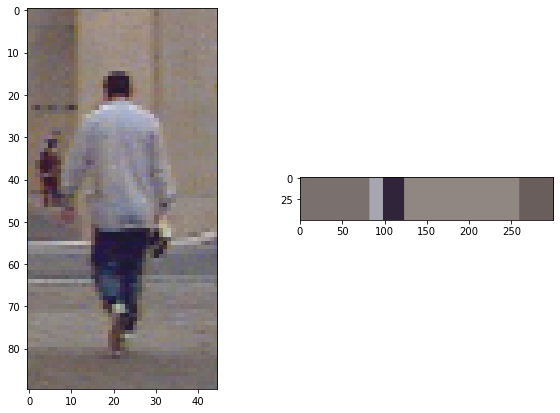



Color Names:  ['dimgray', 'darkslategray', 'darkgray', 'dimgray', 'gray']
Hexadecimal Values:  ['#7b716f', '#30253b', '#a8a7b0', '#6b605d', '#918782']
Resolution of Image:  45 X 90
Time for Prediction : 0.191


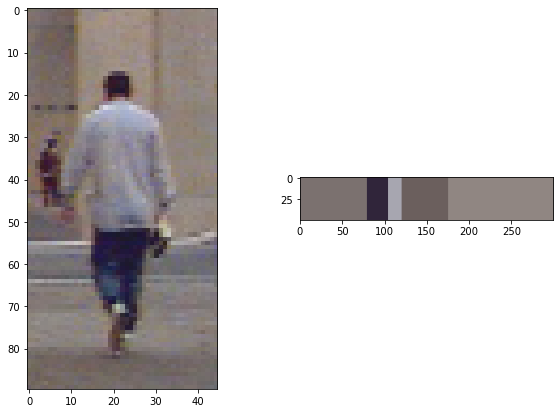



Color Names:  ['dimgray', 'darkslategray', 'lightgray', 'darkslategray', 'gray']
Hexadecimal Values:  ['#746c6e', '#281a32', '#ced1cf', '#59464e', '#918680']
Resolution of Image:  45 X 90
Time for Prediction : 0.257


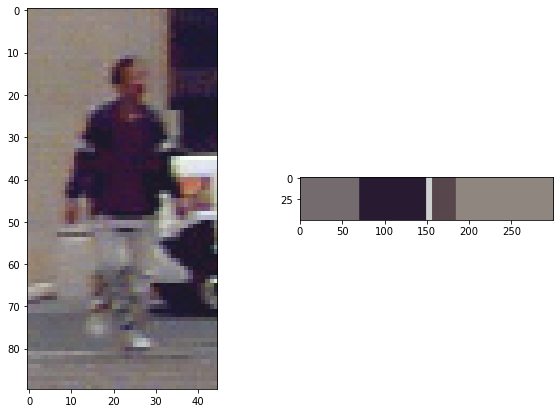



Color Names:  ['rosybrown', 'darkslategray', 'darkgray', 'dimgray', 'gray']
Hexadecimal Values:  ['#ab9894', '#401e3c', '#bdafad', '#673f57', '#8b6a6d']
Resolution of Image:  45 X 90
Time for Prediction : 0.256


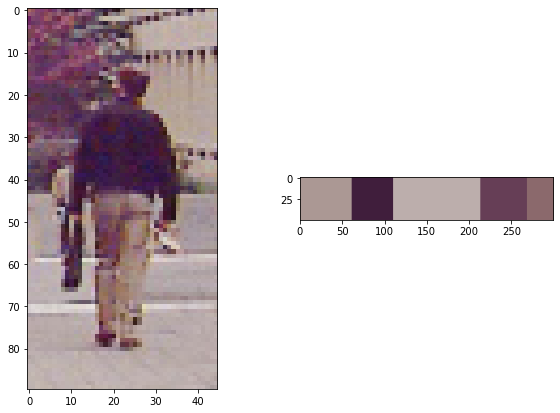



Color Names:  ['darkgray', 'dimgray', 'darkslategray', 'gray', 'silver']
Hexadecimal Values:  ['#b1a09d', '#61485f', '#4b2442', '#8c757c', '#c2b2b0']
Resolution of Image:  45 X 90
Time for Prediction : 0.250


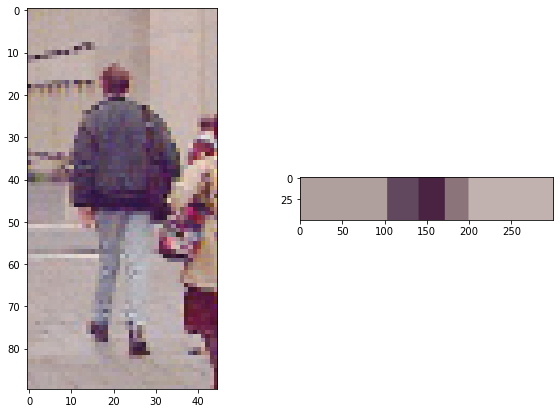



Color Names:  ['darkslategray', 'rosybrown', 'dimgray', 'darkgray', 'dimgray']
Hexadecimal Values:  ['#36193a', '#a69593', '#7a626a', '#baaca9', '#5e4356']
Resolution of Image:  45 X 90
Time for Prediction : 0.368


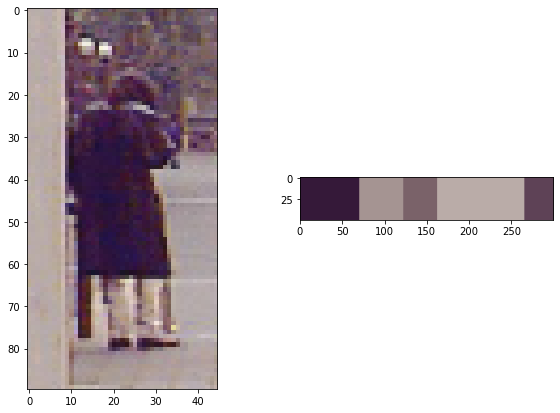



Color Names:  ['dimgray', 'darkgray', 'gray', 'darkslategray', 'gray']
Hexadecimal Values:  ['#6f5d5c', '#b5b0ab', '#979190', '#524853', '#877c79']
Resolution of Image:  45 X 90
Time for Prediction : 0.211


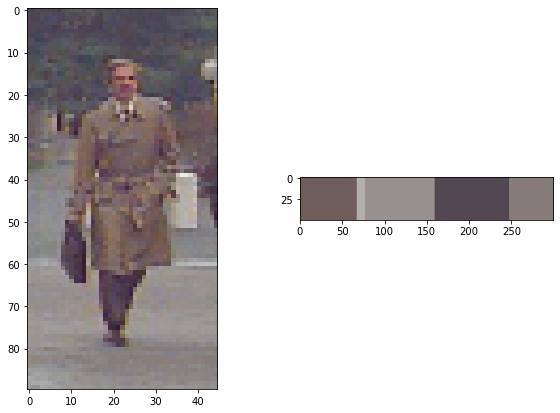



Color Names:  ['rosybrown', 'darkslategray', 'gray', 'darkgray', 'dimgray']
Hexadecimal Values:  ['#9a928f', '#543d5a', '#7f7371', '#aba39f', '#6a5e68']
Resolution of Image:  45 X 90
Time for Prediction : 0.194


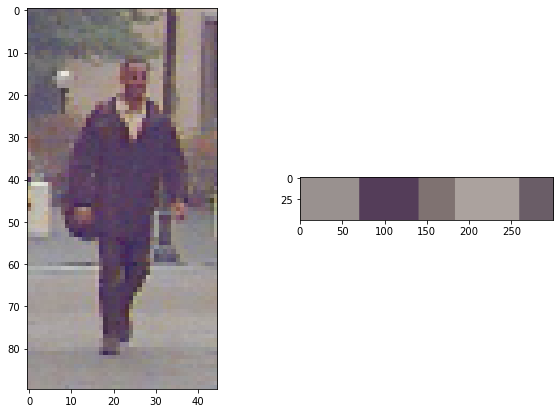



Color Names:  ['silver', 'gray', 'dimgray', 'rosybrown', 'darkslategray']
Hexadecimal Values:  ['#c7c3bf', '#8f837f', '#625b6e', '#a2968d', '#462e51']
Resolution of Image:  45 X 90
Time for Prediction : 0.138


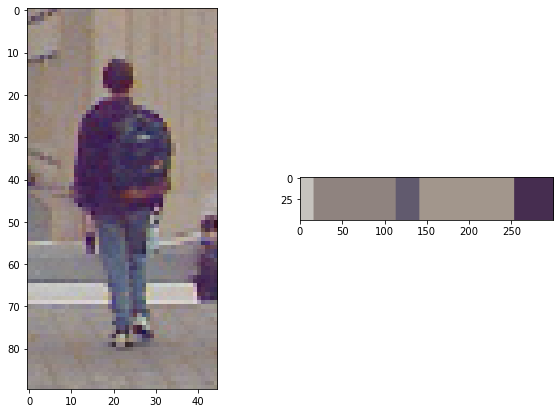



Color Names:  ['darkgray', 'darkslategray', 'dimgray', 'rosybrown', 'darkslategray']
Hexadecimal Values:  ['#bbadaa', '#402241', '#785f69', '#a68f8b', '#563c54']
Resolution of Image:  45 X 90
Time for Prediction : 0.298


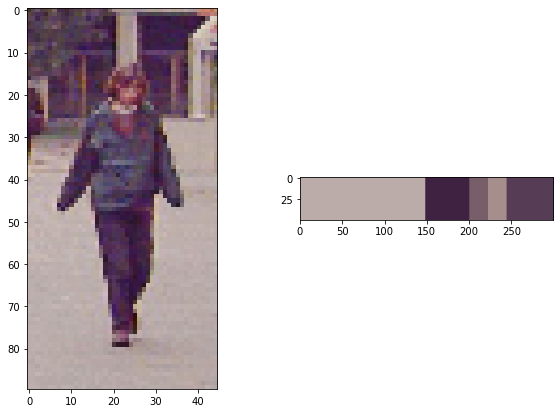

In [10]:
for img in images_peta[:10]:
    get_colors_using_KMeans(img)

#### Results on Caltech Persons dataset

Color Names:  ['black', 'firebrick', 'lightgray', 'indianred', 'darkred']
Hexadecimal Values:  ['#0e050a', '#b23908', '#dfc9be', '#b96648', '#911a03']
Resolution of Image:  336 X 448
Time for Prediction : 4.509


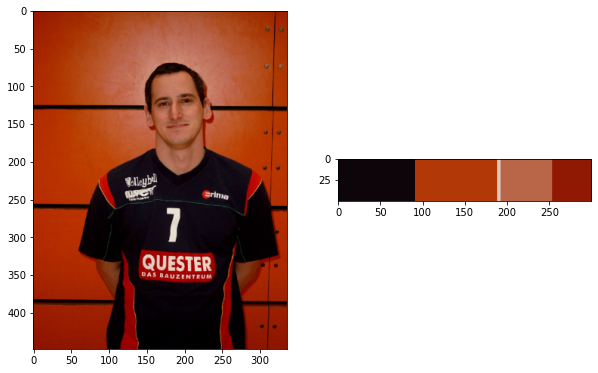



Color Names:  ['darkred', 'black', 'maroon', 'maroon', 'peru']
Hexadecimal Values:  ['#921c02', '#090101', '#5f0501', '#7e0500', '#aa7b5c']
Resolution of Image:  336 X 448
Time for Prediction : 4.083


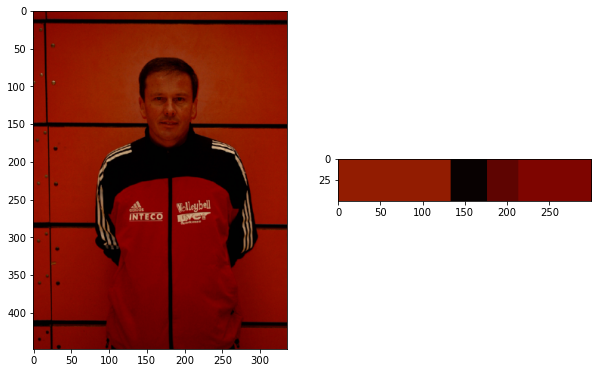



Color Names:  ['firebrick', 'black', 'indianred', 'lightpink', 'darkred']
Hexadecimal Values:  ['#ba440e', '#14090f', '#c27155', '#e5bfb2', '#941d04']
Resolution of Image:  336 X 448
Time for Prediction : 4.725


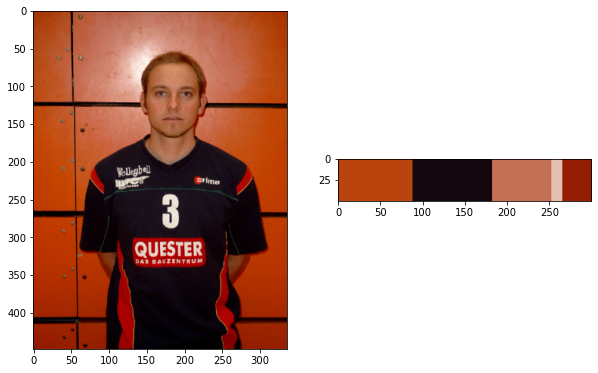



Color Names:  ['maroon', 'darkgray', 'dimgray', 'black', 'silver']
Hexadecimal Values:  ['#51241c', '#999995', '#7d736b', '#161513', '#bec1c0']
Resolution of Image:  336 X 448
Time for Prediction : 4.233


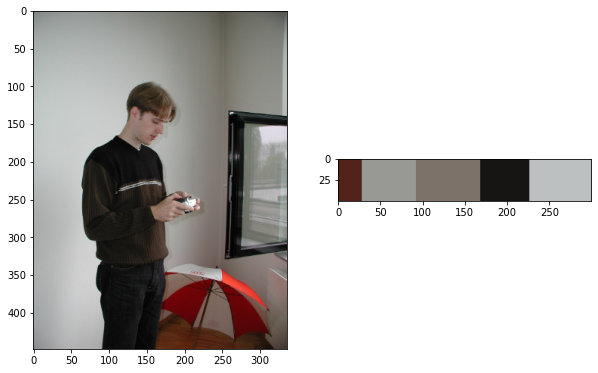



Color Names:  ['dimgray', 'darkgray', 'whitesmoke', 'gray', 'darkslategray']
Hexadecimal Values:  ['#65734e', '#b4b1ae', '#f9f8f8', '#848876', '#3d452e']
Resolution of Image:  336 X 448
Time for Prediction : 4.507


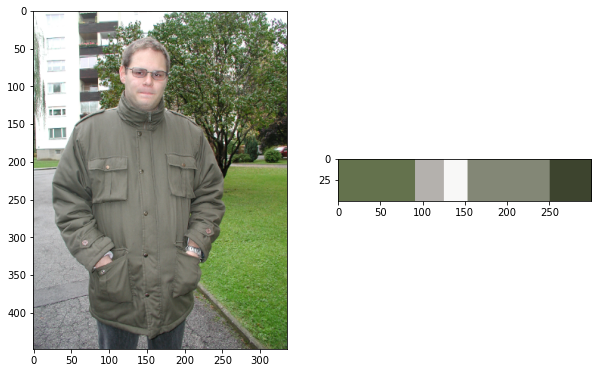



Color Names:  ['darkolivegreen', 'darkgray', 'dimgray', 'silver', 'darkslategray']
Hexadecimal Values:  ['#534c40', '#989e99', '#78756b', '#b6bdbb', '#2d261d']
Resolution of Image:  336 X 448
Time for Prediction : 4.008


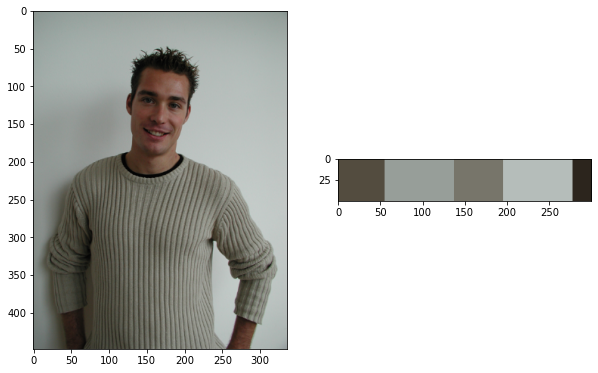



Color Names:  ['dimgray', 'black', 'gray', 'dimgray', 'darkslategray']
Hexadecimal Values:  ['#776c70', '#292022', '#8d8387', '#5c4f52', '#473737']
Resolution of Image:  336 X 448
Time for Prediction : 4.621


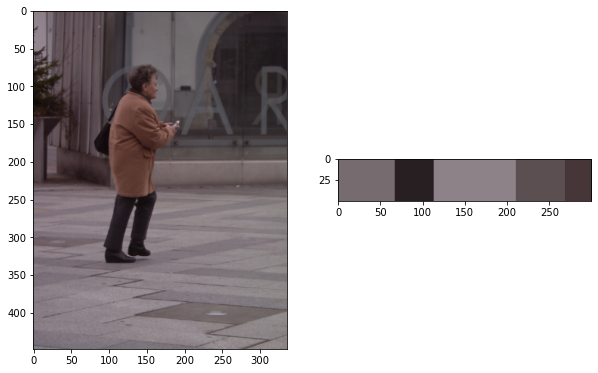



Color Names:  ['dimgray', 'darkslategray', 'dimgray', 'lightslategray', 'black']
Hexadecimal Values:  ['#706471', '#3e313c', '#5a4c58', '#908697', '#231a21']
Resolution of Image:  336 X 448
Time for Prediction : 4.428


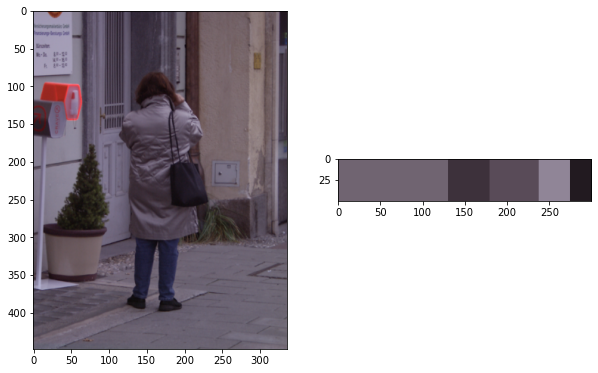



Color Names:  ['lavender', 'black', 'darkgray', 'dimgray', 'darkslategray']
Hexadecimal Values:  ['#eae0e9', '#21171c', '#9d90a1', '#756674', '#523f49']
Resolution of Image:  336 X 448
Time for Prediction : 3.573


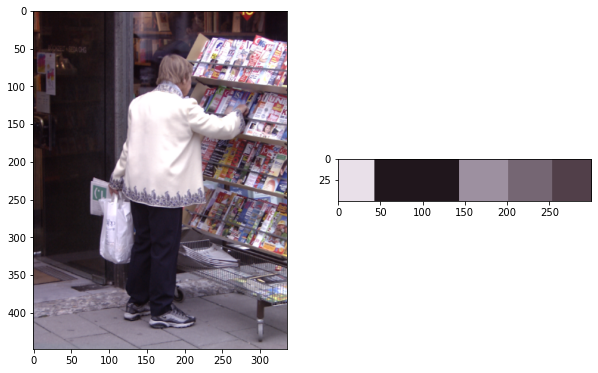



Color Names:  ['darkslategray', 'darkgray', 'black', 'gray', 'dimgray']
Hexadecimal Values:  ['#55494e', '#b5a9a8', '#251a1d', '#918288', '#766970']
Resolution of Image:  336 X 448
Time for Prediction : 2.874


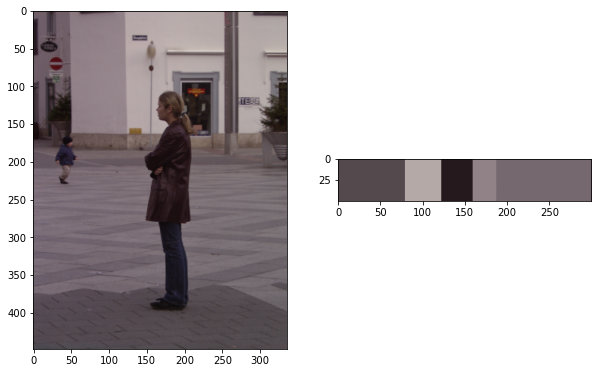

In [11]:
for img in images_person[:10]:
    get_colors_using_KMeans(img)

#### Results on Kaggle dataset

Color Names:  ['lavender', 'crimson', 'rosybrown', 'darkslategray', 'firebrick']
Hexadecimal Values:  ['#e8e8e8', '#e32438', '#be8a74', '#362624', '#ba1520']
Resolution of Image:  424 X 612
Time for Prediction : 4.312


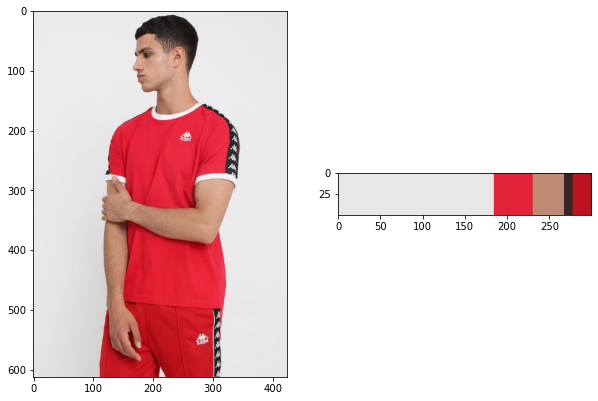



Color Names:  ['gainsboro', 'teal', 'black', 'silver', 'gray']
Hexadecimal Values:  ['#e5e6e6', '#176983', '#171c1d', '#d1aeac', '#80756d']
Resolution of Image:  424 X 612
Time for Prediction : 5.413


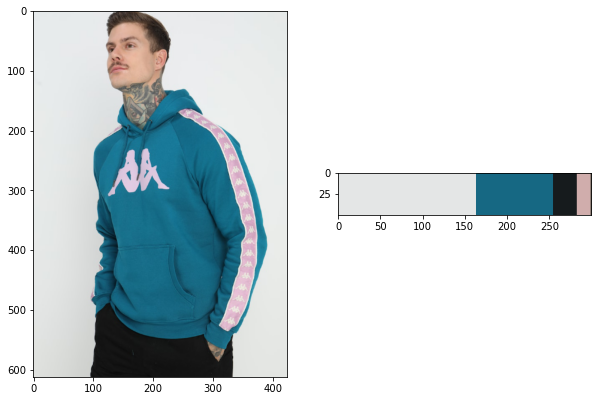



Color Names:  ['linen', 'lightslategray', 'dimgray', 'tan', 'lightgray']
Hexadecimal Values:  ['#ebebe8', '#798392', '#745c55', '#cba28d', '#d8d3cd']
Resolution of Image:  424 X 612
Time for Prediction : 9.478


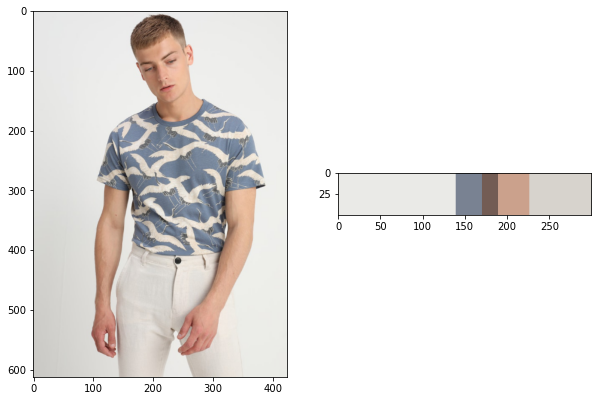



Color Names:  ['black', 'lavender', 'lightseagreen', 'tan', 'dimgray']
Hexadecimal Values:  ['#1c1b1e', '#eaeaeb', '#37aa9f', '#c9a190', '#815c51']
Resolution of Image:  424 X 612
Time for Prediction : 3.857


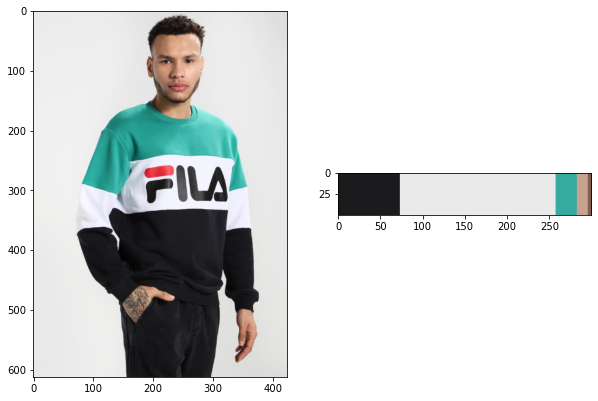



Color Names:  ['whitesmoke', 'black', 'sienna', 'silver', 'crimson']
Hexadecimal Values:  ['#f0f0f0', '#1b1a1a', '#7d5444', '#c3bab9', '#ea2d3a']
Resolution of Image:  424 X 612
Time for Prediction : 6.930


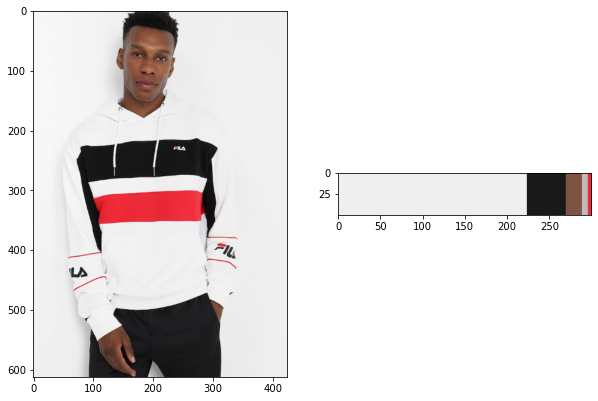



Color Names:  ['dodgerblue', 'whitesmoke', 'dimgray', 'darkslategray', 'rosybrown']
Hexadecimal Values:  ['#2a90de', '#eeeeee', '#866a5a', '#282629', '#cc9d80']
Resolution of Image:  424 X 612
Time for Prediction : 3.640


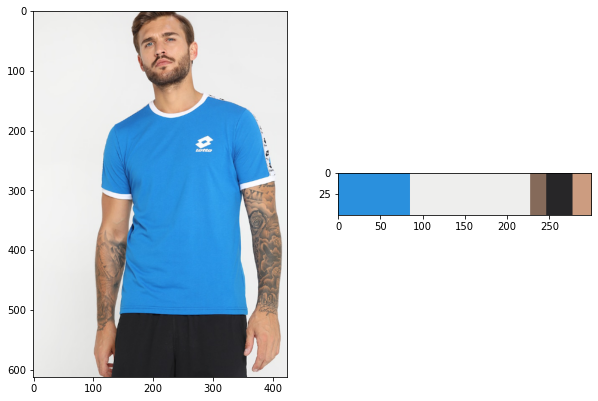

In [12]:
for img in images_kaggle[:]:
    get_colors_using_KMeans(img)

## Output from Pillow's Palette Approach

#### Results on PETA dataset

Actual image size (64, 128)
Hexadecimal Output ['#746d6d', '#8c827e', '#938984', '#554a51', '#82746f', '#a19a99']
Color Names:  ['dimgray', 'gray', 'gray', 'darkslategray', 'gray', 'darkgray']
Time for Prediction : 0.246


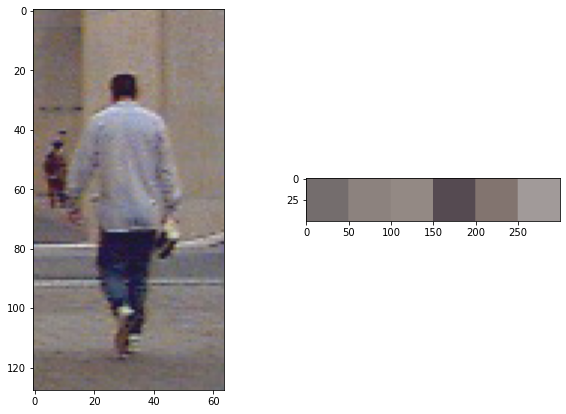



Actual image size (64, 128)
Hexadecimal Output ['#746d6d', '#8c827e', '#938984', '#554a51', '#82746f', '#a19a99']
Color Names:  ['dimgray', 'gray', 'gray', 'darkslategray', 'gray', 'darkgray']
Time for Prediction : 0.053


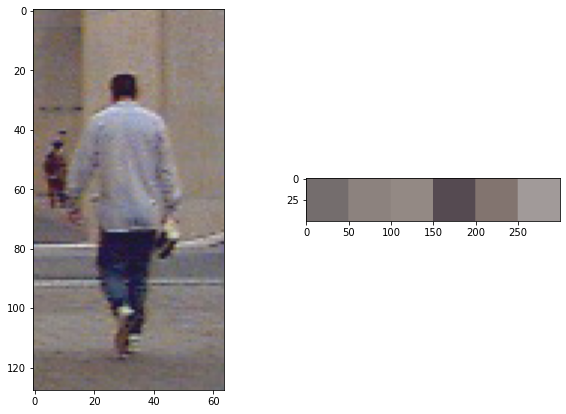



Actual image size (64, 128)
Hexadecimal Output ['#261830', '#92877f', '#867c79', '#736467', '#514651', '#a29c97']
Color Names:  ['darkslategray', 'gray', 'gray', 'dimgray', 'darkslategray', 'darkgray']
Time for Prediction : 0.070


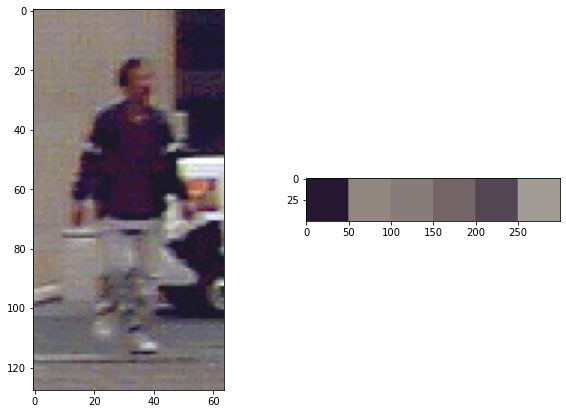



Actual image size (64, 128)
Hexadecimal Output ['#482241', '#bbadab', '#b2a09d', '#714a5d', '#947a78', '#c7bbb7']
Color Names:  ['darkslategray', 'darkgray', 'darkgray', 'dimgray', 'gray', 'silver']
Time for Prediction : 0.072


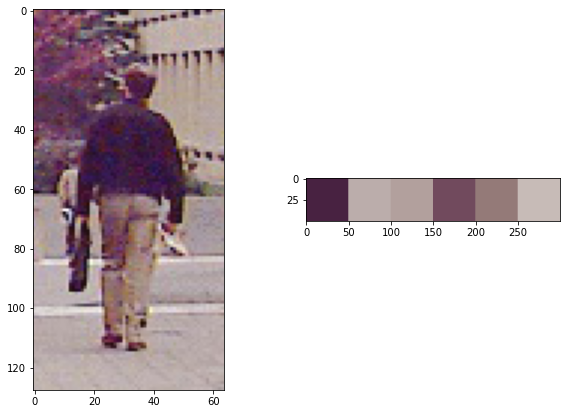



Actual image size (64, 128)
Hexadecimal Output ['#56354f', '#b8a9a5', '#bfb0ae', '#b39c9a', '#cabbb6', '#988a8f']
Color Names:  ['darkslategray', 'darkgray', 'darkgray', 'rosybrown', 'silver', 'gray']
Time for Prediction : 0.084


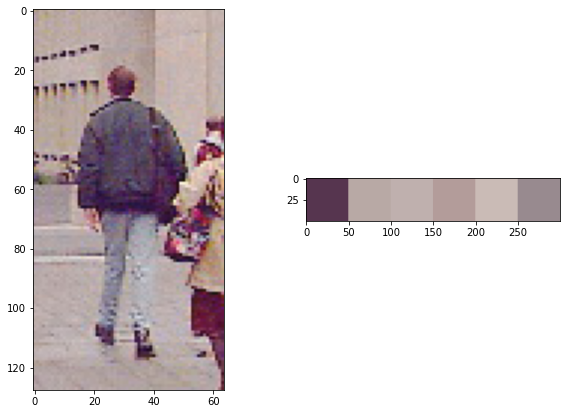



Actual image size (64, 128)
Hexadecimal Output ['#35193a', '#b8aba7', '#ab9c9a', '#604457', '#7c656b', '#c3b5b0']
Color Names:  ['darkslategray', 'darkgray', 'darkgray', 'dimgray', 'dimgray', 'silver']
Time for Prediction : 0.071


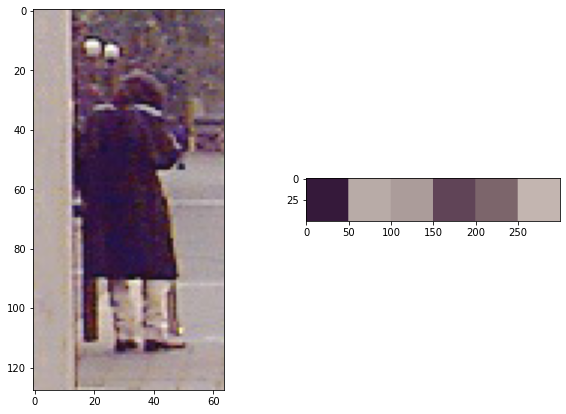



Actual image size (64, 128)
Hexadecimal Output ['#948f8e', '#50434f', '#887d7a', '#745e5c', '#5c585b', '#a39e9a']
Color Names:  ['gray', 'darkslategray', 'gray', 'dimgray', 'dimgray', 'darkgray']
Time for Prediction : 0.071


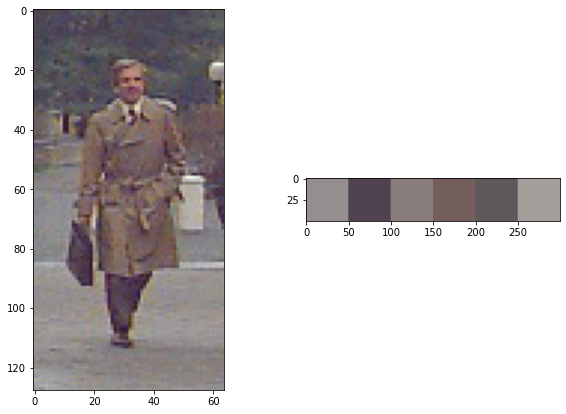



Actual image size (64, 128)
Hexadecimal Output ['#543c59', '#a69e99', '#99908e', '#7f6d6f', '#666069', '#b3aba4']
Color Names:  ['darkslategray', 'darkgray', 'gray', 'dimgray', 'dimgray', 'darkgray']
Time for Prediction : 0.076


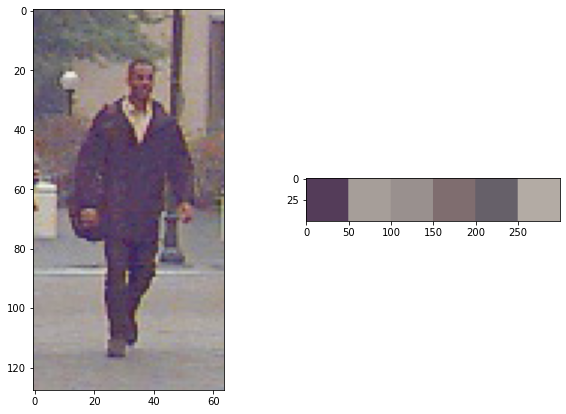



Actual image size (64, 128)
Hexadecimal Output ['#a4988d', '#4c3857', '#9a8f88', '#95837e', '#827c7e', '#b3aa9f']
Color Names:  ['rosybrown', 'darkslategray', 'gray', 'gray', 'gray', 'darkgray']
Time for Prediction : 0.068


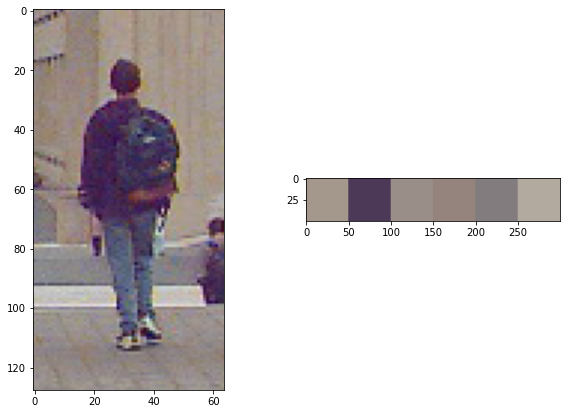

In [13]:
images_peta = 'PETA_dataset/MIT/archive/'
count=0
for filename in os.listdir(images_peta):
    count+=1
    if filename.endswith('.jpg') and count<11:
        display_output(os.path.join(images_peta,filename))

#### Results on Caltech Persons dataset

Actual image size (480, 640)
Hexadecimal Output ['#0a040a', '#ae3808', '#a42001', '#b4562e', '#be765f', '#5e1206']
Color Names:  ['black', 'firebrick', 'firebrick', 'sienna', 'indianred', 'maroon']
Time for Prediction : 0.245


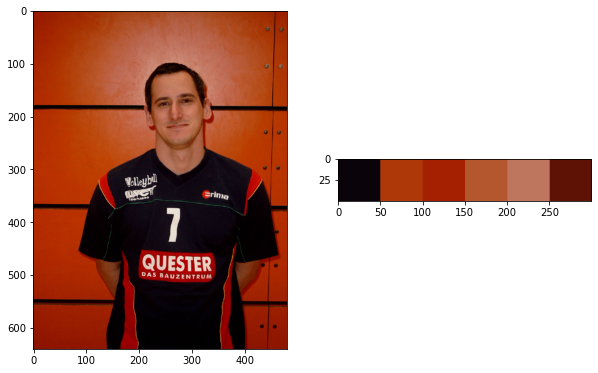



Actual image size (480, 640)
Hexadecimal Output ['#770200', '#8d1400', '#8f1e01', '#320201', '#850500', '#8e3311']
Color Names:  ['maroon', 'darkred', 'darkred', 'black', 'maroon', 'saddlebrown']
Time for Prediction : 0.081


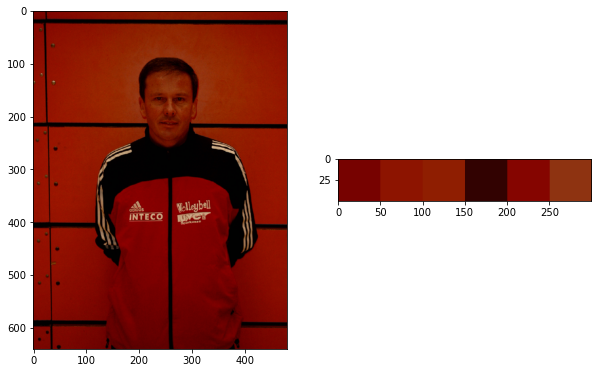



Actual image size (480, 640)
Hexadecimal Output ['#10070e', '#b74a15', '#ae2802', '#be684a', '#d1907b', '#5f190a']
Color Names:  ['black', 'sienna', 'firebrick', 'indianred', 'darksalmon', 'maroon']
Time for Prediction : 0.089


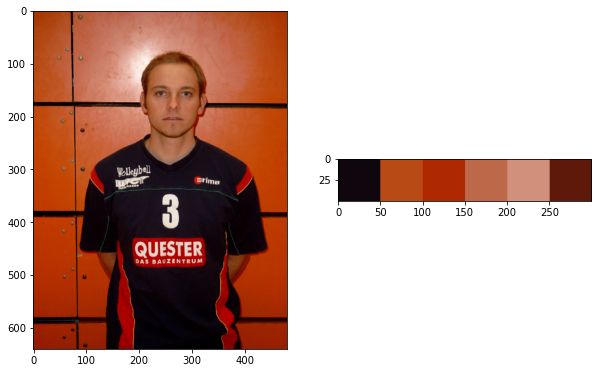



Actual image size (480, 640)
Hexadecimal Output ['#231c18', '#807a72', '#979793', '#b5b7b7', '#c7cbca', '#735049']
Color Names:  ['black', 'gray', 'darkgray', 'silver', 'silver', 'dimgray']
Time for Prediction : 0.046


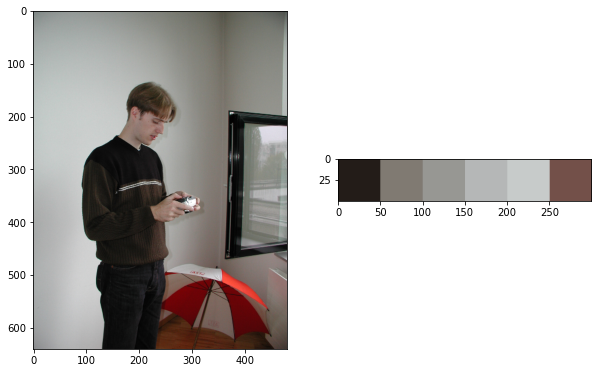



Actual image size (480, 640)
Hexadecimal Output ['#6e7360', '#4b4f3e', '#8c8b83', '#728955', '#e4e3e2', '#95a37e']
Color Names:  ['dimgray', 'darkslategray', 'gray', 'dimgray', 'gainsboro', 'darkseagreen']
Time for Prediction : 0.112


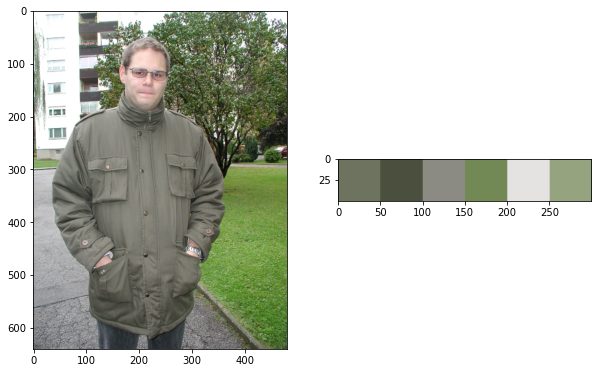



Actual image size (480, 640)
Hexadecimal Output ['#474035', '#99a19d', '#6e6a5f', '#bdc4c2', '#aeb6b3', '#82837a']
Color Names:  ['darkslategray', 'darkgray', 'dimgray', 'silver', 'darkgray', 'gray']
Time for Prediction : 0.075


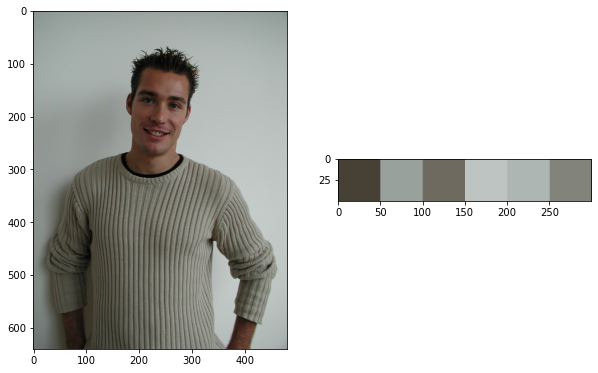



Actual image size (480, 640)
Hexadecimal Output ['#35292a', '#7b7175', '#524a4d', '#8a8085', '#92888c', '#685658']
Color Names:  ['darkslategray', 'gray', 'darkslategray', 'gray', 'gray', 'dimgray']
Time for Prediction : 0.093


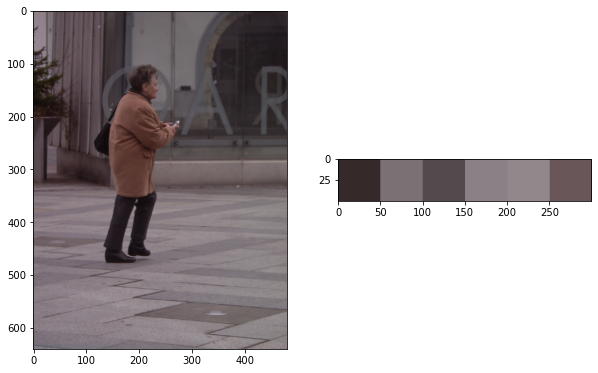



Actual image size (480, 640)
Hexadecimal Output ['#6d626f', '#332932', '#776a76', '#514654', '#685460', '#8d8394']
Color Names:  ['dimgray', 'darkslategray', 'dimgray', 'darkslategray', 'dimgray', 'lightslategray']
Time for Prediction : 0.126


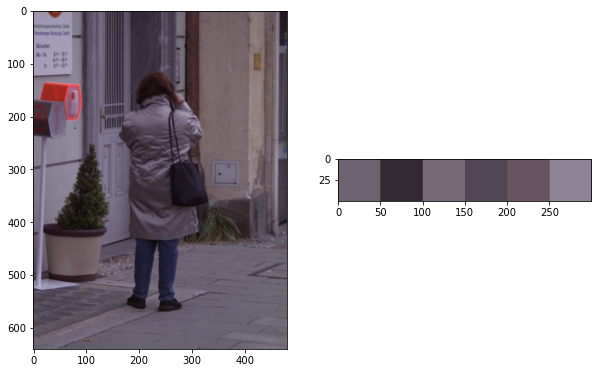



Actual image size (480, 640)
Hexadecimal Output ['#1c1319', '#7f707f', '#5a454f', '#aa9dac', '#ece3eb', '#352932']
Color Names:  ['black', 'gray', 'darkslategray', 'darkgray', 'lavender', 'darkslategray']
Time for Prediction : 0.082


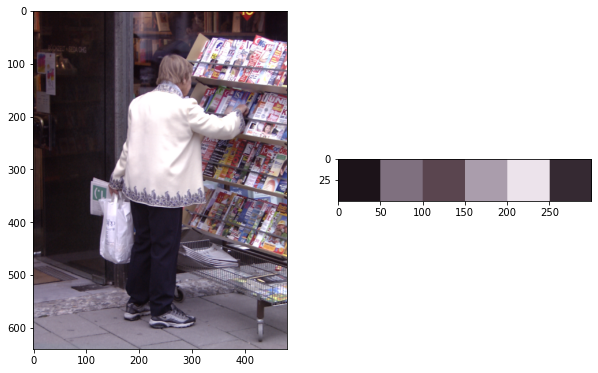



Actual image size (480, 640)
Hexadecimal Output ['#796d73', '#584e53', '#6d5f65', '#b6aaa9', '#3b3034', '#8d8085']
Color Names:  ['dimgray', 'dimgray', 'dimgray', 'darkgray', 'darkslategray', 'gray']
Time for Prediction : 0.148


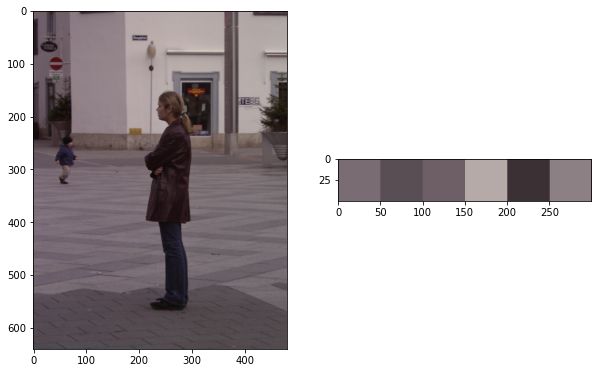

In [14]:
images_person = 'persons/'
count=0
for filename in os.listdir(images_person):
    count+=1
    if count<11:
        display_output(os.path.join(images_person,filename))

#### Results on Kaggle dataset

Actual image size (606, 875)
Hexadecimal Output ['#c91e2e', '#e8e8e8', '#ececec', '#b17968', '#eaeaea', '#dcd1cd']
Color Names:  ['crimson', 'lavender', 'whitesmoke', 'indianred', 'lavender', 'lightgray']
Time for Prediction : 0.064


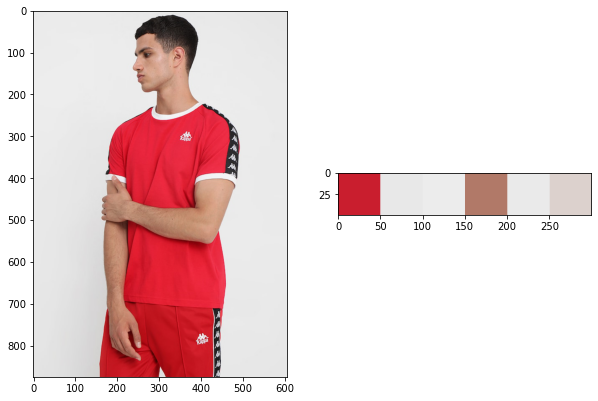



Actual image size (606, 875)
Hexadecimal Output ['#17718d', '#e1e3e2', '#e8eaeb', '#ebeded', '#184757', '#aea8ab']
Color Names:  ['teal', 'gainsboro', 'lavender', 'whitesmoke', 'darkslategray', 'darkgray']
Time for Prediction : 0.041


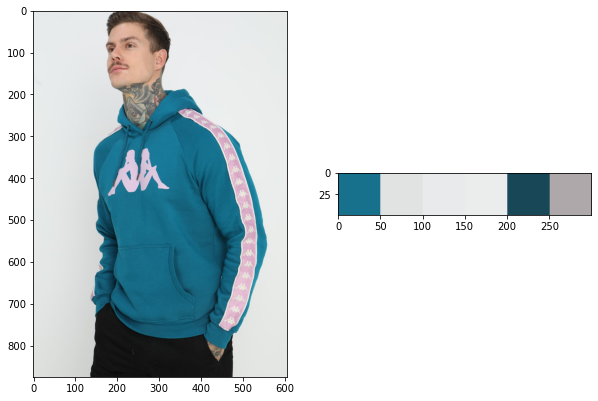



Actual image size (606, 875)
Hexadecimal Output ['#948381', '#eeeeeb', '#ecebe9', '#e6e4e1', '#decec3', '#cdc9c4']
Color Names:  ['gray', 'linen', 'linen', 'gainsboro', 'lightgray', 'silver']
Time for Prediction : 0.083


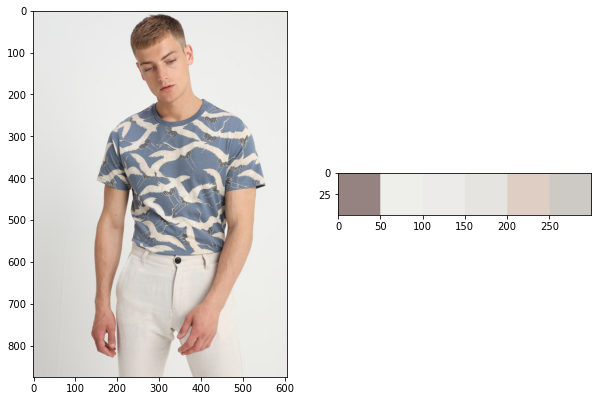



Actual image size (606, 875)
Hexadecimal Output ['#e9eaea', '#221f21', '#ededed', '#70988c', '#f0f0f1', '#cbdcda']
Color Names:  ['lavender', 'black', 'whitesmoke', 'lightslategray', 'whitesmoke', 'lightgray']
Time for Prediction : 0.039


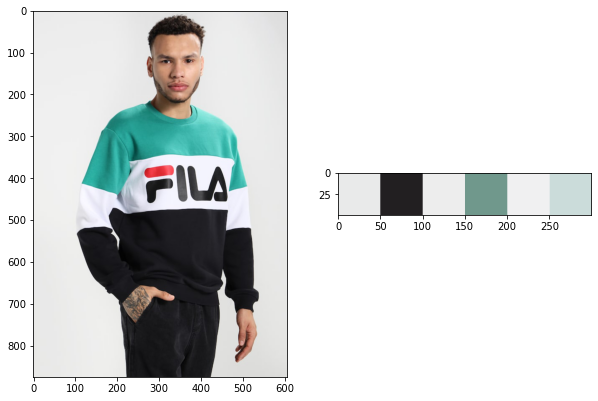



Actual image size (606, 875)
Hexadecimal Output ['#efefef', '#4f2c2a', '#f1f1f1', '#f0f0f0', '#f5f6f6', '#e4e2e2']
Color Names:  ['whitesmoke', 'darkslategray', 'whitesmoke', 'whitesmoke', 'whitesmoke', 'gainsboro']
Time for Prediction : 0.037


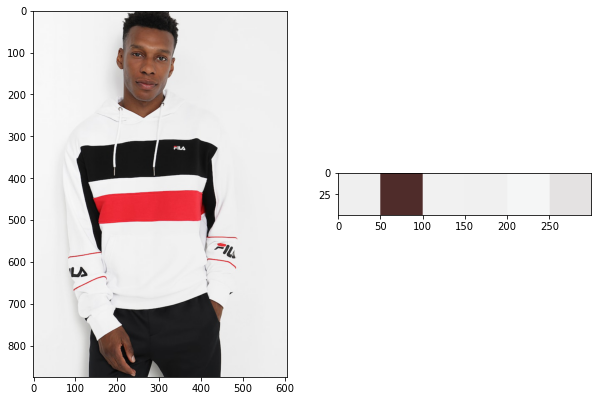



Actual image size (606, 875)
Hexadecimal Output ['#2991e1', '#efefed', '#f2f2f1', '#4a5a6a', '#e4e1df', '#5e98c4']
Color Names:  ['dodgerblue', 'whitesmoke', 'whitesmoke', 'dimgray', 'gainsboro', 'steelblue']
Time for Prediction : 0.052


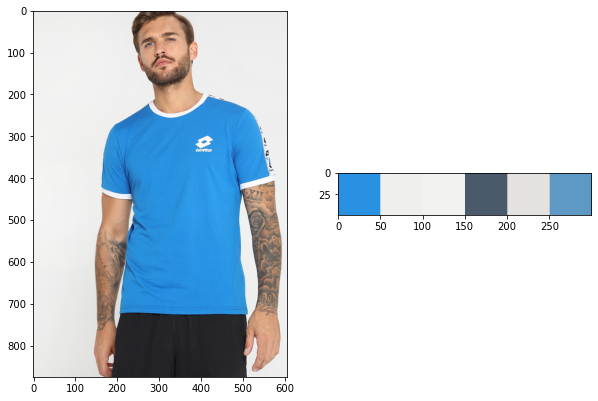

In [15]:
images_kaggle = 'Kaggle_images/'
count=0
for filename in os.listdir(images_kaggle):
    count+=1
    if filename.endswith('.jpg') and count<11:
        display_output(os.path.join(images_kaggle,filename))